# Dutch street network sandbox

In [1]:
import matplotlib.pyplot as plt
from pprint import pprint
from collections import defaultdict
from datetime import datetime, timedelta
import seaborn as sns
import numpy as np
import osmnx as ox
import networkx as nx
import pandas as pd
import copy
import os

# Geopandas modules
import geopandas as gpd
from geopandas.tools import sjoin
from shapely.geometry import Point # Create point from (lon, lat)
from shapely.geometry import Polygon, MultiPolygon
from descartes import PolygonPatch

Selected geodata from The Netherlands ([Wijk- en buurtkaart 2019](https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/wijk-en-buurtkaart-2019)) and cross with income data ([CBS 2017](https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS&tableId=83765NED&_theme=230)).

In [2]:
# Data sources
# https://geoservices.zuid-holland.nl

# Graph name
city = "Rotterdam"

# Region
region = "Rotterdam, The Netherlands"

# Assumption = People in Rotterdam Zuid have distinct travel patterns
zuid_districts = ["Charlois", "IJsselmonde", "Feijenoord"]

# Filter districts
district_filter = ["Hoek van Holland", "Rozenburg", "Pernis", "Hoogvliet", "Waalhaven-Eemhaven"]

# Filter neighborhoods
neighborhood_filter_list = ["Heijplaat", "Noord Kethel", "Schieveen"]

speed_km_h = 20
max_travel_time_edge = 30 # seconds at speed_km_h

graph_name = region.lower().replace(" ", "-").replace(",", "")
graph_filename = f"{graph_name}.graphml"
city_name = city.lower().replace(" ","_")

# Directory where data will be saved (absolute path is necessary)
directory = "C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/notebooks/"

# Where input NL data is saved
directory_data = "../notebooks/data/nl/"

# Folders
folder_data = f"{directory}data/"
folder = f"{directory}output/{city_name}/"
folder_network = f"{folder}network/"
folder_img = f"{folder}figures/"
folder_shp = f"{folder}shp/"
folder_shp_districts = f"{folder_shp}districts/"
folder_shp_neighborhoods = f"{folder_shp}neighborhoods/"
folder_shp_points = f"{folder_shp}points/"

folder_list = [
    folder_img,
    folder_shp,
    folder_shp_districts,
    folder_shp_neighborhoods,
    folder_shp_points
]

pprint(folder_list)

# Creating folder1s
for f in folder_list:
    if not os.path.exists(f):
        os.makedirs(f)

format = ".png"
# Imgs
path_img_network_original = f"{folder_img}street_network_original{format}"
path_img_street_network_points = f"{folder_img}street_network_points{format}"
path_img_street_network_points_cleaned = f"{folder_img}street_network_points_cleaned{format}"
path_img_street_network_neighbors=f"{folder_img}street_network_neighbors{format}"
path_hexbins = f"{folder_img}hexbins{format}"
path_overlay_hexbins = f"{folder_img}overlay_hexbins{format}"
path_station_noord_zuid = f"{folder_img}station_noord_zuid{format}"
path_img_residents = f"{folder_img}residents{format}"

### Dataframes
path_node_hex = f"{folder}{city_name}_node_hex.csv"
path_node_station_hex = f"{folder}{city_name}_node_station_hex.csv"
path_bus_stops = f"{folder}{city_name}_bus_stops.csv"
path_nodes_dist_neigh = f"{folder}{city_name}_nodes_dist_neigh.csv"
network_path = f"{folder}{graph_name}.graphml"
path_dist_matrix_npy = f"{folder_network}distance_matrix_m.npy"

### Shapes
path_shp_districts = f"{folder_shp_districts}{city_name}_districts.shp"
path_city_geopoints = f"{folder_shp_points}{city_name}_network_points.shp"
path_shp_neighborhoods = f"{folder_shp_neighborhoods}{city_name}_neighborhoods.shp"

### Input data
path_stations = f"{directory_data}nl_train_stations.csv" # Train stations
path_stats = f"{directory_data}nl_census_2017.csv" # Dutch stats
path_stops = f"{directory_data}nl_bus_stops.csv" # Bus stops

# Filter minimum population size
min_pop = 1000
year_stats = 2017

# Get district and neighbor paths
paths = {
    2019:("2019/buurt_2019_v1.shp" , "2019/wijk_2019_v1.shp", "2019/gemeente_2019_v1.shp"),
    2017:("2017/buurt_2017_v3.shp" , "2017/wijk_2017_v3.shp", "2017/gemeente_2017_v3.shp")
}
paths = {k:(f"{directory_data}nl_district_neighbors/{s}" for s in v) for k,v in paths.items()}

# Path neighborhood (buurten) data AND Path district (wijken) data
neighborhood_shp, district_shp, gemeente_shp  = paths[2019]

# Loading districts and neighborhoods
shapefile_wijk = gpd.read_file(district_shp)
shapefile_buurt = gpd.read_file(neighborhood_shp)
shapefile_gemeente = gpd.read_file(gemeente_shp)

['C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/notebooks/output/rotterdam/figures/',
 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/notebooks/output/rotterdam/shp/',
 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/notebooks/output/rotterdam/shp/districts/',
 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/notebooks/output/rotterdam/shp/neighborhoods/',
 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/notebooks/output/rotterdam/shp/points/']


In [3]:
print("BU:", list(shapefile_buurt.keys()))
print("WK:", list(shapefile_wijk.keys()))
print("GE:", list(shapefile_gemeente.keys()))

BU: ['BU_CODE', 'JRSTATCODE', 'BU_NAAM', 'WK_CODE', 'WK_NAAM', 'GM_CODE', 'GM_NAAM', 'IND_WBI', 'WATER', 'POSTCODE', 'DEK_PERC', 'OAD', 'STED', 'BEV_DICHTH', 'AANT_INW', 'AANT_MAN', 'AANT_VROUW', 'P_00_14_JR', 'P_15_24_JR', 'P_25_44_JR', 'P_45_64_JR', 'P_65_EO_JR', 'P_ONGEHUWD', 'P_GEHUWD', 'P_GESCHEID', 'P_VERWEDUW', 'AANTAL_HH', 'P_EENP_HH', 'P_HH_Z_K', 'P_HH_M_K', 'GEM_HH_GR', 'P_WEST_AL', 'P_N_W_AL', 'P_MAROKKO', 'P_ANT_ARU', 'P_SURINAM', 'P_TURKIJE', 'P_OVER_NW', 'OPP_TOT', 'OPP_LAND', 'OPP_WATER', 'geometry']
WK: ['WK_CODE', 'JRSTATCODE', 'WK_NAAM', 'GM_CODE', 'GM_NAAM', 'IND_WBI', 'WATER', 'OAD', 'STED', 'BEV_DICHTH', 'AANT_INW', 'AANT_MAN', 'AANT_VROUW', 'P_00_14_JR', 'P_15_24_JR', 'P_25_44_JR', 'P_45_64_JR', 'P_65_EO_JR', 'P_ONGEHUWD', 'P_GEHUWD', 'P_GESCHEID', 'P_VERWEDUW', 'AANTAL_HH', 'P_EENP_HH', 'P_HH_Z_K', 'P_HH_M_K', 'GEM_HH_GR', 'P_WEST_AL', 'P_N_W_AL', 'P_MAROKKO', 'P_ANT_ARU', 'P_SURINAM', 'P_TURKIJE', 'P_OVER_NW', 'OPP_TOT', 'OPP_LAND', 'OPP_WATER', 'geometry']
GE: 

Columns filtered:

|  Column    | Description                         |
|-----------:|:------------------------------------|
|`GM_NAAM`   |Gemeentenaam                         |
|`WK_NAAM`   |Wijknaam                             |
|`BU_NAAM`   |Buurtnaam                            |
|`AANT_INW`  |Aantal inwoners                      |
|`P_15_24_JR`|Percentage personen 15 tot 25 jaar   |
|`P_25_44_JR`|Percentage personen 25 tot 45 jaar   |
|`P_45_64_JR`|Percentage personen 45 tot 65 jaar   |
|`P_65_EO_JR`|Percentage personen 65 jaar en ouder |
|`BEV_DICHTH`|aantal inwoners per km2              |
|`geometry`  |geodata (multi-polygon)              |


Filter districts by: city, min. population and district black list.

In [4]:
# Filter columns
shapefile_wijk = shapefile_wijk[[
    "GM_NAAM",
    "WK_CODE",
    "WK_NAAM",
    "AANT_INW",
    #"BEV_DICHTH",
    #"P_15_24_JR",
    #"P_25_44_JR",
    #"P_45_64_JR",
    #"P_65_EO_JR",
    "geometry"
]]

# Filters
city_filter = (shapefile_wijk["GM_NAAM"]==city) # Geement Naam = City
min_pop_filter = (shapefile_wijk["AANT_INW"]>=min_pop) # Aantal inwoners = N. of inhabitants
district_filter = (~shapefile_wijk["WK_NAAM"].isin(district_filter)) # Wijk naam = District name

# Filtered districts
wijk_shp = shapefile_wijk[city_filter & min_pop_filter & district_filter]

# Show data
population = sum(set(wijk_shp["AANT_INW"]))
districts = set(wijk_shp["WK_NAAM"])
print(f"Districts from {city} with more than {min_pop:,} inhabitants:")
pprint(districts)

Districts from Rotterdam with more than 1,000 inhabitants:
{'Charlois',
 'Delfshaven',
 'Feijenoord',
 'Hillegersberg-Schiebroek',
 'IJsselmonde',
 'Kralingen-Crooswijk',
 'Noord',
 'Overschie',
 'Prins Alexander',
 'Rotterdam Centrum'}


Filter neighborhood data:

In [5]:
# Filter columns
shapefile_buurt = shapefile_buurt[[
    "GM_NAAM",
    "WK_NAAM",
    "BU_CODE",
    "BU_NAAM",
    "AANT_INW",
    #"BEV_DICHTH",
    #"P_15_24_JR",
    #"P_25_44_JR",
    #"P_45_64_JR",
    #"P_65_EO_JR",
    "geometry"
]]

district_filter = (shapefile_buurt["WK_NAAM"].isin(districts))
city_filter = (shapefile_buurt["GM_NAAM"]==city)
neighborhood_filter = (~shapefile_buurt["BU_NAAM"].isin(neighborhood_filter_list))
#min_pop_filter = (shapefile_buurt["AANT_INW"]>=min_pop) # Aantal inwoners = N. of inhabitants

buurt_shp = shapefile_buurt[city_filter & district_filter & neighborhood_filter]

# Show data
neighborhoods = set(buurt_shp["BU_NAAM"])
print(f"Neighborhoods from '{city}' within the selected districts:")
print(list(neighborhoods))

Neighborhoods from 'Rotterdam' within the selected districts:
['Overschie', 'Landzicht', 'Molenlaankwartier', 'Struisenburg', 'Prinsenland', 'Groot IJsselmonde', 'Terbregge', 'Zuiderpark', 'De Esch', 'Schiebroek', 'Noordereiland', 'Provenierswijk', 'Kralingen Oost', 'Oud Mathenesse', 'Zuidwijk', 'Hillegersberg Zuid', 'Oosterflank', 'Zuidplein', 'Nieuw Crooswijk', 'Vreewijk', 'Schiemond', 'Zestienhoven', 'Bloemhof', 'Katendrecht', 'Afrikaanderwijk', 'Stadsdriehoek', 'Spangen', 'Tussendijken', 'Kralingen West', 'Nesselande', 'Blijdorp', 'Middelland', 'Tarwewijk', 'Cool', 'Dijkzigt', 'Kleinpolder', "'s Gravenland", 'Bergpolder', 'Ommoord', 'Agniesebuurt', 'Oude Noorden', 'Feijenoord', 'Charlois Zuidrand', 'Carnisse', 'Oude Westen', 'Oud IJsselmonde', 'Blijdorpsepolder', 'Witte Dorp', 'Nieuwe Werk', 'Kralingse Bos', 'Pendrecht', 'Oud Crooswijk', 'Beverwaard', 'Bospolder', 'Kralingseveer', 'Het Lage Land', 'Wielewaal', 'Hillesluis', 'Zevenkamp', 'Delfshaven', 'Cs Kwartier', 'Hillegersberg N

In [6]:
buurt_shp

,GM_NAAM,WK_NAAM,BU_CODE,BU_NAAM,AANT_INW,geometry
6718,Rotterdam,Rotterdam Centrum,BU05990110,Stadsdriehoek,16390,"POLYGON ((92349.580 437925.056, 92375.713 4379..."
6719,Rotterdam,Rotterdam Centrum,BU05990111,Oude Westen,9445,"POLYGON ((91412.788 437507.740, 91415.880 4375..."
6720,Rotterdam,Rotterdam Centrum,BU05990112,Cool,5735,"POLYGON ((91925.500 437499.710, 91933.681 4375..."
6721,Rotterdam,Rotterdam Centrum,BU05990113,Cs Kwartier,1020,"POLYGON ((92326.078 437923.110, 92329.379 4379..."
6722,Rotterdam,Rotterdam Centrum,BU05990118,Nieuwe Werk,1755,"POLYGON ((92366.606 436291.783, 92369.250 4362..."
...,...,...,...,...,...,...
6785,Rotterdam,Charlois,BU05991574,Oud Charlois,13760,"POLYGON ((91162.000 434931.000, 91176.872 4349..."
6786,Rotterdam,Charlois,BU05991575,Wielewaal,420,"POLYGON ((91205.945 433249.497, 91227.890 4332..."
6787,Rotterdam,Charlois,BU05991576,Zuidplein,1265,"POLYGON ((93046.460 433834.390, 93049.450 4338..."
6788,Rotterdam,Charlois,BU05991577,Pendrecht,12390,"POLYGON ((90875.580 431872.570, 90940.980 4319..."


## Population in districts and neighborhoods

In [7]:
buurt_shp["share_residents"] = buurt_shp["AANT_INW"]/sum(buurt_shp["AANT_INW"])
wijk_shp["share_residents"] = wijk_shp["AANT_INW"]/sum(wijk_shp["AANT_INW"])

C:\Users\LocalAdmin\anaconda3\envs\env_slevels\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\LocalAdmin\anaconda3\envs\env_slevels\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


MAX: 0.16468636082261504
MAX: 0.049607026080354756


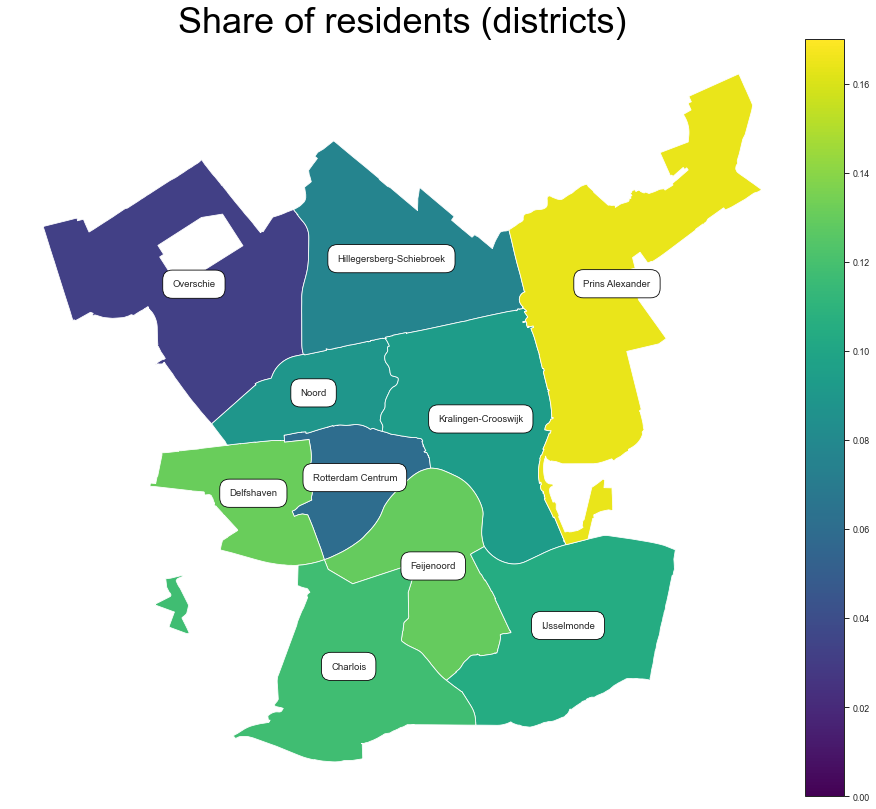

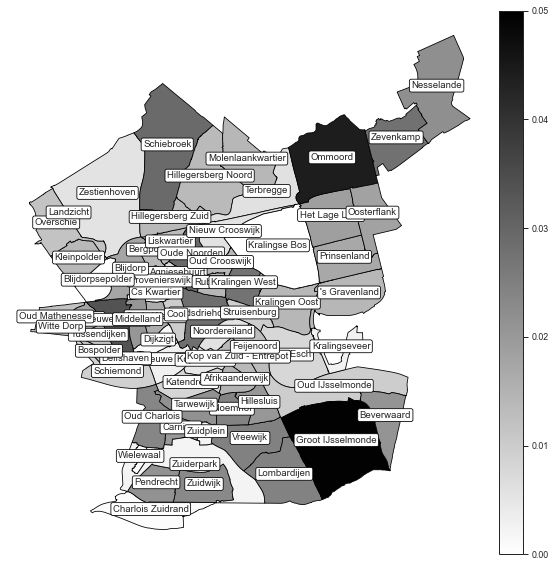

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig_w, ax_w = plt.subplots(1, 1, figsize=(15, 15))

sns.set_style("white")
sns.set_context("paper")


# Color based on
color_column = "share_residents"
# Setup population bar from districts
divider1 = make_axes_locatable(ax_w)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)

print("MAX:", max(wijk_shp[color_column]))
wijk_shp.plot(column=color_column, cmap="viridis",  vmin=0, vmax=0.17, ax=ax_w, legend=True, cax=cax1)
ax_w.axis("off")
ax_w.set_title("Share of residents (districts)", fontsize=36)


# Annotate district names
_ = wijk_shp.apply(
        lambda x: ax_w.annotate(
            s=x.WK_NAAM,
            xy=x.geometry.centroid.coords[0],
            ha='center',
            bbox=dict(
                facecolor='white',
                edgecolor='black',
                boxstyle='round,pad=1'
            )
        ),
        axis=1
    )

fig_res, ax_res = plt.subplots(1, 1, figsize=(10, 10))

# Annotate neighborhood names
_ = buurt_shp.apply(
        lambda x: ax_res.annotate(
            s=x.BU_NAAM,
            xy=x.geometry.centroid.coords[0],
            ha='center',
            bbox=dict(
                facecolor='white',
                edgecolor='black',
                boxstyle='round,pad=0.2'
            )
        ),
        axis=1
    )

# Setup population bar from neighborhoods
print("MAX:", max(buurt_shp[color_column]))
divider2 = make_axes_locatable(ax_res)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
buurt_shp.plot(column=color_column, cmap="binary", edgecolor="black", legend=True, vmin=0, vmax=0.05, ax=ax_res, cax=cax2)


ax_res.axis("off")
#ax[1].set_title("Number of residents (neighborhoods)", fontsize=28)


fig_res.savefig(path_img_residents, bbox_inches="tight", pad_inches=0)

## Plot network over geographic areas

Get the street network graph of the city from openstreetmaps:


In [9]:
G_original = ox.graph_from_place(region, network_type="drive", simplify=True)

TypeError: Geometry must be a shapely Polygon or MultiPolygon. If you requested graph from place name or address, make sure your query resolves to a Polygon or MultiPolygon, and not some other geometry, like a Point. See OSMnx documentation for details.

In [ ]:
import sys
import logging
logging.basicConfig(level=logging.INFO)

# Network module includes the "clean_network" function
# to get the largest strongly connected graph.

sys.path.insert(0, "../../tenv/tenv/")
import network as nw

# Get network graph and save
G = nw.get_network_from(
    region,
    folder_network,
    graph_name,
    graph_filename,
    max_travel_time_edge,
    speed_km_h,
)

nw.save_graph_pic(G, folder_img)

In [ ]:
# Project graph using Dutch CRS
G_proj_original = ox.project_graph(G_original, to_crs=('EPSG:28992'))

# Plot street network projection
fig, ax = ox.plot_graph(
    G_proj_original,
    fig_height=10,
    node_color="#C0C0C0",
    node_size=1,
    edge_linewidth=0.5,
    node_zorder=0,
    edge_color="#D3D3D3",
    show=False,
    close=False,
)#, node_edgecolor='k', edge_color='#777777')

fig.savefig(path_img_network_original, bbox_inches="tight", pad_inches=0)

### Dataframe from street network

Create a geopandas dataframe from graph nodes (node id, lon, lat):

In [ ]:
data = defaultdict(list)
for n in G_original.nodes():
    data["id"].append(n)
    x=G_original.nodes[n]["x"]
    y=G_original.nodes[n]["y"]
    data["lon"].append(x)
    data["lat"].append(y)

df_points = pd.DataFrame.from_dict(data)
geometry = [Point(xy) for xy in zip(df_points.lon, df_points.lat)]

# geopandas from graph
geo_points = gpd.GeoDataFrame(df_points, geometry=geometry, crs="EPSG:4326")
geo_points = geo_points.to_crs('EPSG:28992')

Add district and neighborhood names to points (check if point is within polygon) and drop unmatched nodes:

In [ ]:
geo_points = gpd.sjoin(geo_points, wijk_shp[["WK_NAAM","geometry"]], how="left", op='within')
geo_points.drop("index_right", axis=1,inplace=True)

geo_points = gpd.sjoin(geo_points, buurt_shp[["BU_NAAM","geometry"]], how="left", op='within')
geo_points.drop("index_right", axis=1,inplace=True)
geo_points.dropna(inplace=True)

# Nodes that do not belong to any neighborhood 
# or district are removed (`WK_NAAM = NaN` or `BU_NAAM = NaN`).
geo_points[["id", "lon", "lat", "WK_NAAM", "BU_NAAM"]].rename(columns={"WK_NAAM":"district", "BU_NAAM":"neighborhood"}).to_csv(path_nodes_dist_neigh, index=False)
geo_points.head(5)

In [ ]:
ax = geo_points.plot(figsize=(10,10), legend=True, color="k", markersize=0.3)
#ax.set_title(f"Street network nodes in {city} area")
_ = ax.axis("off")
plt.savefig(path_img_street_network_points, bbox_inches="tight", pad_inches=0)

Removing nodes that are not covered by district/neighborhood areas.

In [ ]:
import sys
import logging
logging.basicConfig(level=logging.INFO)

# Network module includes the "clean_network" function
# to get the largest strongly connected graph.

import network as nw

try:
    print(f"Loading graph '{network_path}'.")
    G = ox.load_graphml(network_path, folder=folder)
    geo_points = gpd.read_file(path_city_geopoints)

except Exception as e:
    print(f"Cannot load data! Exception: '{e}'")
    G = copy.deepcopy(G_original)
    print("# Original graph:")
    print(nw.get_graph_info(G))

    print(f"\n# Removing nodes:")
    nodes_to_remove = set(G.nodes) - set(geo_points["id"])
    G.remove_nodes_from(nodes_to_remove)
    print("Nodes to remove:", len(nodes_to_remove))
    print(nw.get_graph_info(G))

    print("\n# Cleaning network:")
    G_cleaned = nw.clean_network(G)
    print(nw.get_graph_info(G_cleaned))
    removed = set(G.nodes) - set(G_cleaned)
    print(f"Removed: {len(removed)}.")

    print("\n# After relabel:")
    mapping = {k: i for i, k in enumerate(sorted(G_cleaned.nodes))}
    G = nx.relabel_nodes(G_cleaned, mapping)
    
    # Remove exlcluded points
    geo_points = geo_points[~geo_points["id"].isin(removed)].copy()
    geo_points["id"] = geo_points["id"].apply(lambda row: mapping[row])
    geo_points.sort_values(by="id", inplace=True)
    
    # Save points
    geo_points.to_file(path_city_geopoints)
    
    # Save graphs
    ox.save_graphml(G, filename=network_path, folder=folder)

print(nw.get_graph_info(G))
geo_points

In [ ]:
ax = geo_points.plot(figsize=(10,10), legend=True, color="k", markersize=0.3)
#ax.set_title(f"Street network nodes in {city} area")
_ = ax.axis("off")
plt.savefig(path_img_street_network_points_cleaned, bbox_inches="tight", pad_inches=0)

### Creating the distance matrix

Get the shortest path between all nodes in graph:


In [ ]:
distance_matrix_m = nw.get_distance_dic(path_dist_matrix_npy, G)

print("Loaded distance matrix:", type(distance_matrix_m), distance_matrix_m.shape)

In [ ]:
geo_points

In [ ]:
# ##### CRS (Coordinate Reference System)
#  4326 = WGS 84 - WGS84 - World Geodetic System 1984, used in GPS
# 28992 = Amersfoort / RD New -- Netherlands - Holland - Dutch

# Project graph using CRS of Dutch data
G_proj = ox.project_graph(G, to_crs=('EPSG:28992'))

In [ ]:
# Plot projection
fig, ax = ox.plot_graph(
    G_proj,
    fig_height=10,
    fig_width=20,
    node_color="#C0C0C0",
    node_size=1,
    edge_linewidth=0.5,
    node_zorder=0,
    edge_color="#D3D3D3",
    show=False,
    close=False,
)#, node_edgecolor='k', edge_color='#777777')
plt.close()

Plotting neighborhoods and annotations:

Plot district boundaries over street network:

In [ ]:
sns.set_context("paper")
sns.set_style("white")

# Plot street network projection
fig_snet, ax_snet = ox.plot_graph(
    G_proj,
    fig_height=12,
    margin=0.2,
    node_color="#C0C0C0",
    node_size=1,
    edge_linewidth=0.5,
    node_zorder=0,
    edge_color="#D3D3D3",
    show=False,
    close=False,
)#, node_edgecolor='k', edge_color='#777777')
plt.close()

# Plot district boundaries
wijk_shp.geometry.boundary.plot(ax=ax_snet, color='red', linewidth=1,zorder=100)

# Annotate district names
_ = wijk_shp.apply(
        lambda x: ax_snet.annotate(
            s=x.WK_NAAM,
            xy=x.geometry.centroid.coords[0],
            ha='center',
            bbox=dict(
                facecolor='white',
                edgecolor='silver',
                boxstyle='round,pad=0.5'
            ),
            zorder=200,
        ),
        axis=1
    )

fig_snet.savefig(path_img_street_network_neighbors) #, bbox_inches="tight", pad_inches=0)
fig_snet

## Creating hexbins to aggregate nodes

Using  [H3](https://eng.uber.com/h3/) grid system, Uber’s hexagonal hierarchical spatial index.

Table of Cell Areas for H3 Resolutions ([link](https://h3geo.org/#/documentation/core-library/resolution-table)):

Resolutions used:

|H3 <br>Resolution | Average Hexagon<br>Area (km2) | Average Hexagon<br>Edge Length (km)|
|:-------------:|:---------------------------:|:--------------------------------:|
|6|6.1290521|3.229482772|
|7|5.1612932|1.220629759|
|8|0.7373276|0.461354684|
|9|0.1053325|0.174375668|
|10|0.0150475|0.065907807|
|11|0.0021496|0.024910561|

In [ ]:
from h3 import h3
def hex_geo(lat, lon, res):
    """Return hexbin id and geometries of hexagon covering (lon, lat) at resoluton res"""
    # Get the index
    h = h3.geo_to_h3(lat=lat,lng=lon, res=res)
    
    # Find the geographic boundariy [[coord1], [coord2], ...,[coord6]]
    geo = h3.h3_to_geo_boundary(h3_address=h)
    
    # Create polygon (invert lat/lon)
    poly = Polygon([[c[1], c[0]] for c in geo])

    # Lon, lat coordinates of hexagon centroid
    centroid = poly.centroid
    
    # Find in G the nearest intersection to the centroid
    node_id = ox.get_nearest_node(G, (centroid.y, centroid.x), return_dist=False)
    
    # Get the (lon, lat) of the node
    node_gps = Point(G.nodes[node_id]["x"], G.nodes[node_id]["y"])

    return (h, poly, centroid, node_id, node_gps)

# Dataframe with the hexbin info
geo_points_hex = copy.deepcopy(geo_points)
geo_points_hex = geo_points_hex.to_crs('EPSG:4326')

# H3 supports sixteen resolutions. Each finer resolution has cells with one seventh 
# the area of the coarser resolution. Hexagons cannot be perfectly subdivided into 
# seven hexagons, so the finer cells are only approximately contained within a parent cell.
hex_res = [9, 8, 7]
for i, res in enumerate(hex_res):
    geo_points_hex[
        [
            f"hex_{res:02}",
            f"geo_{res:02}",
            f"centroid_{res:02}",
            f"centroid_node_{res:02}",
            f"centroid_node_gps_{res:02}"
        ]
    ] = geo_points.apply(
            lambda row: hex_geo(
                row.lat,
                row.lon,
                res=res
            ),
            axis=1,
            result_type='expand'
    )

In [ ]:
geo_points_hex = geo_points_hex.dropna()
geo_points_hex.sort_values(by=["id", "hex_07", "hex_08", "hex_09"], inplace=True)
geo_points_hex[[
    "id", "lon", "lat", "WK_NAAM", "BU_NAAM",
    "hex_07", "hex_08", "hex_09",
    "centroid_07", "centroid_08", "centroid_09",
    "centroid_node_07", "centroid_node_08", "centroid_node_09",]
].rename(columns={"WK_NAAM":"district", "BU_NAAM":"neighborhood"}).to_csv(path_node_hex, index=False)

geo_points_hex

In [ ]:
sns.set_context("paper")
sns.set_style("white")

color_levels = ["r", "b", "gray"]
legend_levels = ["1", "2", "3"]
fig, ax = plt.subplots(1, len(hex_res), figsize=(len(hex_res)*10, 10))
fig_overlay, ax_overlay = plt.subplots(1, 1, figsize=(10, 10))

for i, res in enumerate(hex_res):

    # Isolate elements of a single resolution and drop duplicates
    geo_hex = geo_points_hex.drop_duplicates(f"hex_{res:02}")[[f"hex_{res:02}", f"geo_{res:02}", f"centroid_{res:02}", f"centroid_node_{res:02}", f"centroid_node_gps_{res:02}"]]

    # Create geodf for hexagons
    geo_hex_df = gpd.GeoDataFrame(geo_hex[f"hex_{res:02}"], geometry=geo_hex[f"geo_{res:02}"])
    geo_hex_df.crs = 'EPSG:4326'
    
    # Create geodf for the centroid
    geo_centroid_df = gpd.GeoDataFrame(geo_hex[f"centroid_{res:02}"], geometry=geo_hex[f"centroid_{res:02}"])
    geo_centroid_df.crs = 'EPSG:4326'

    # Create geodf for the closest network node from centroid
    geo_centroid_node_df = gpd.GeoDataFrame(geo_hex[f"centroid_node_gps_{res:02}"], geometry=geo_hex[f"centroid_node_gps_{res:02}"])
    geo_centroid_node_df.crs = 'EPSG:4326'

    geo_hex_df.to_crs('EPSG:28992').plot(ax=ax[i], color='white', edgecolor='black', linewidth=1)
    geo_hex_df.boundary.to_crs('EPSG:28992').plot(ax=ax_overlay, color=color_levels[i], label=legend_levels[i], linewidth=1+len(legend_levels)-i, zorder=len(legend_levels)-i)
    
    geo_centroid_df.to_crs('EPSG:28992').plot(ax=ax[i], color="black", markersize=2, label="Hexbin centroid")
    geo_centroid_node_df.to_crs('EPSG:28992').plot(ax=ax[i], color="red", markersize=1, label="Nearest node in map")
    n_hex = len(geo_hex[f"hex_{res:02}"])
    ax[i].set_title(f"#Hexbins: {n_hex} (resolution={res})", size=18)
    ax[i].legend(frameon=False, loc="best")
    ax[i].axis("off")

fig.savefig(path_hexbins, bbox_inches='tight', pad_inches=0)
ax_overlay.legend(frameon=False, loc=(0,0), title="Hierarchical levels", fontsize=16, title_fontsize=16, ncol=len(hex_res))
ax_overlay.axis("off")
fig_overlay.savefig(path_overlay_hexbins, bbox_inches="tight", pad_inches=0)

plt.show()

In [ ]:
sns.set_context("paper")
sns.set_style("white")

color_levels = ["r", "b", "#C0C0C0"]
legend_levels = ["1", "2", "3"]
alpha_levels = [1, 0.5, 1]
linewidth_levels = [1,2,3]
fig_overlay, ax_overlay = plt.subplots(1, 1, figsize=(20, 20))

for i, res in enumerate(hex_res):

    # Isolate elements of a single resolution and drop duplicates
    geo_hex = geo_points_hex.drop_duplicates(f"hex_{res:02}")[[f"hex_{res:02}", f"geo_{res:02}", f"centroid_{res:02}", f"centroid_node_{res:02}", f"centroid_node_gps_{res:02}"]]

    # Create geodf for hexagons
    geo_hex_df = gpd.GeoDataFrame(geo_hex[f"hex_{res:02}"], geometry=geo_hex[f"geo_{res:02}"])
    geo_hex_df.crs = 'EPSG:4326'
    geo_hex_df.boundary.to_crs('EPSG:28992').plot(
        ax=ax_overlay,
        color=color_levels[i],
        label=legend_levels[i],
        alpha=alpha_levels[i],
        linewidth=linewidth_levels[i],
        zorder=len(legend_levels)-i
    )

ax_overlay.legend(
    frameon=False,
    loc=(0.8,1/2),
    title="Levels",
    fontsize=32,
    title_fontsize=32,
    #ncol=len(hex_res)
)

ax_overlay.axis("off")
fig_overlay.savefig(path_overlay_hexbins, bbox_inches="tight", pad_inches=0)

plt.show()

# Merging income statistical data

In [ ]:
df_nl_stats = pd.read_csv(path_stats)

col_rename = {
    "GemiddeldInkomenPerInkomensontvanger_65":"avg_income_per_income_receiver",
    "k_40PersonenMetLaagsteInkomen_67":"people_lowest_income",
    "HuishOnderOfRondSociaalMinimum_73":"house_under_social_minimum",
    "GemiddeldInkomenPerInwoner_66":"avg_income_per_people",
}
# Change column name for join
df_nl_stats = df_nl_stats.rename(columns=col_rename)


df_nl_stats_buurt = df_nl_stats.rename(columns={"WijkenEnBuurten":"BU_CODE"})
df_nl_stats_buurt = df_nl_stats_buurt[df_nl_stats_buurt['SoortRegio_2'].apply(lambda row:row.strip())=="Buurt"]

df_nl_stats_wijk = df_nl_stats.rename(columns={"WijkenEnBuurten":"WK_CODE"})
df_nl_stats_wijk = df_nl_stats_wijk[df_nl_stats_wijk['SoortRegio_2'].apply(lambda row:row.strip())=="Wijk"]

df_nl_stats_wijk = df_nl_stats_wijk[list(col_rename.values())+["WK_CODE"]]
df_nl_stats_buurt = df_nl_stats_buurt[list(col_rename.values())+["BU_CODE"]]

# Remove invalid whitespaces
for col in list(col_rename.values())+["WK_CODE"]:
    df_nl_stats_wijk[col] = df_nl_stats_wijk[col].apply(lambda row:row.strip())
    df_nl_stats_wijk = df_nl_stats_wijk[df_nl_stats_wijk[col]!="."]

for col in list(col_rename.values())+["BU_CODE"]:
    df_nl_stats_buurt[col] = df_nl_stats_buurt[col].apply(lambda row:row.strip())
    df_nl_stats_buurt = df_nl_stats_buurt[df_nl_stats_buurt[col]!="."]

In [ ]:
df_nl_stats

In [ ]:
df_nl_stats[df_nl_stats["Gemeentenaam_1"]=="Rijswijk"]

In [ ]:
df_nl_stats_wijk

In [ ]:
wijk_shp

### Merging stats to districts

In [ ]:
#color_column = "house_under_social_minimum"
#color_column = "people_lowest_income"
color_column = "avg_income_per_people"
title = {"avg_income_per_people":"Avg. income"}
wijk_shp_stats = pd.merge(wijk_shp, df_nl_stats_wijk, how="left", on="WK_CODE")
wijk_shp_stats = wijk_shp_stats.astype({
    "avg_income_per_income_receiver":float,
    "people_lowest_income":float,
    "house_under_social_minimum":float,
    "avg_income_per_people":float
})

wijk_shp_stats

In [ ]:
# Convert to geopandas again after changing types
wijk_shp_stats = gpd.GeoDataFrame(wijk_shp_stats)
fig, ax = plt.subplots(1,1,figsize=(15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
wijk_shp_stats.plot(column=color_column, cmap="plasma", ax=ax, legend=True, cax=cax)
ax.set_title(f"{title[color_column]}", fontsize=36)
ax.axis("off")

In [ ]:
buurt_shp

### Merging stats to neighborhoods

In [ ]:
buurt_shp_stats = pd.merge(buurt_shp, df_nl_stats_buurt, how="left", on="BU_CODE")

buurt_shp_stats = buurt_shp_stats.astype({
    "avg_income_per_income_receiver":float,
    "people_lowest_income":float,
    "house_under_social_minimum":float,
    "avg_income_per_people":float
})
buurt_shp_stats

In [ ]:
# Convert to geopandas again after changing types
buurt_shp_stats = gpd.GeoDataFrame(buurt_shp_stats)
fig, ax = plt.subplots(1,1,figsize=(10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
buurt_shp_stats.plot(column=color_column, cmap="plasma", ax=ax, legend=True, cax=cax)
ax.set_title(f"{color_column}")

### Load bus stops

In [ ]:
df_stops = pd.read_csv(path_stops)

# Select focus city
df_city = df_stops[df_stops["town"]==city]

print("Original with duplicated stations:")
df_city

In [ ]:
df_city = df_city.drop_duplicates("name")
print("After dropping duplicate bus stops:")
df_city.sort_values(by="rd_x")

In [ ]:
# Create list of points
geometry_stops = df_city.apply(lambda x:Point(x.longitude, x.latitude), axis=1)

# Create geopandas df
geo_stops = gpd.GeoDataFrame(df_city[["id", "name", "latitude", "longitude"]], geometry=geometry_stops)
geo_stops["name"] = geo_stops["name"].apply(
    lambda x: x.replace('Rotterdam, ','')
)

geo_stops.crs = ('EPSG:4326')
geo_stops.head(10)

# Simulating demand

Pickup probability is based on the relative population of districts and neighborhoods.

Save districts:

In [ ]:
wijk_shp2 = wijk_shp.to_crs('EPSG:4326')
wijk_shp2["AANT_INW_AVG"] = wijk_shp2["AANT_INW"]/sum(wijk_shp2["AANT_INW"])
wijk_shp2.sort_values(by=["WK_NAAM"], inplace=True)
wijk_shp2[[
    "WK_CODE", "WK_NAAM", "AANT_INW", "AANT_INW_AVG", "geometry"
]].rename(columns={
    "WK_CODE":"distr_code",
    "WK_NAAM":"distr_name",
    "AANT_INW":"n_resident",
    "AANT_INW_AVG":"mean_resid"}).to_file(path_shp_districts)
wijk_shp2

Save neighborhoods:

In [ ]:
buurt_shp2 = buurt_shp.to_crs('EPSG:4326')
buurt_shp2["AANT_INW_AVG"] = buurt_shp2["AANT_INW"]/sum(buurt_shp2["AANT_INW"])
buurt_shp2.sort_values(by=["WK_NAAM"], inplace=True)
buurt_shp2[[
    "WK_NAAM", "BU_NAAM", "BU_CODE", "AANT_INW", "AANT_INW_AVG", "geometry"
]].rename(columns={
    "BU_CODE":"neigh_code",
    "WK_NAAM":"distr_name",
    "BU_NAAM":"neigh_name",
    "AANT_INW":"n_resident",
    "AANT_INW_AVG":"mean_resid"}).to_file(path_shp_neighborhoods)
buurt_shp2

In [ ]:
####################################################################
##### Each stop belongs to a district and neighborhood #############
####################################################################
# Join districts to stops
geo_stops = gpd.sjoin(geo_stops, wijk_shp2[["WK_NAAM","geometry"]], how="left", op='within')
geo_stops.drop("index_right", axis=1,inplace=True)

# Join neighborhoods to stops
geo_stops = gpd.sjoin(geo_stops, buurt_shp2[["BU_NAAM","geometry"]], how="left", op='within')
geo_stops.drop("index_right", axis=1,inplace=True)
geo_stops.dropna(inplace=True)

# Find the nearest node in G of each stop
geo_stops["node_id"] = geo_stops.apply(
    lambda x:ox.get_nearest_node(
        G,
        (x.latitude, x.longitude),
        method="haversine"
    ),
    axis=1,
)

geo_stops.rename(columns={"WK_NAAM":"district", "BU_NAAM":"neighborhood"}).to_csv(path_bus_stops)
geo_stops

In [ ]:
geo_stops = geo_stops.drop_duplicates("node_id")

### Load train stations

In [ ]:
df_stations = pd.read_csv(path_stations)
geometry_stations = df_stations.apply(lambda x:Point(x.geo_lng, x.geo_lat), axis=1)
geo_stations = gpd.GeoDataFrame(df_stations, geometry=geometry_stations)
geo_stations.crs = ('EPSG:4326')

# Join districts to stops
geo_stations = gpd.sjoin(geo_stations, wijk_shp2[["WK_NAAM","geometry"]], how="left", op='within')
geo_stations.drop("index_right", axis=1,inplace=True)

# Join neighborhoods to stops
geo_stations = gpd.sjoin(geo_stations, buurt_shp2[["BU_NAAM","geometry"]], how="left", op='within')
geo_stations.drop("index_right", axis=1,inplace=True)
geo_stations.dropna(inplace=True)

# Add network id
geo_stations["node_id"] = geo_stations.apply(
    lambda x:ox.get_nearest_node(
        G,
        (x.geo_lat, x.geo_lng),
        method="haversine"
    ),
    axis=1,
)
geo_stations.head(10)

Plotting bus stops and train stations:

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.set_context("paper")
sns.set_style("white")
buurt_shp2.to_crs('EPSG:28992').plot(ax=ax, color='white', edgecolor='black')
geo_stops.to_crs('EPSG:28992').plot(ax=ax, label="Bus stops", marker='o', alpha=0.5, color='white', edgecolor='red', linewidth=1, markersize=10)
geo_stations.to_crs('EPSG:28992').plot(ax=ax, label="Train stations", marker='o', color='black', linewidth=3, markersize=20)
ax.legend()

ax.set_title(f"Bus stops and train stations in {city}", fontsize=24)

# Plot stations
geo_stations.to_crs('EPSG:28992').apply(
        lambda x: ax.annotate(
            #s=f"{x.korte_naam}\n({x.type.replace('station','')})",
            s=f"{x.naam.replace('Rotterdam','')}",
            xy=np.array(x.geometry.centroid.coords[0])+np.array([0, 300]),
            ha='center',
            bbox=dict(
                facecolor='white',
                edgecolor='black',
                boxstyle='round,pad=0.4'
            )
        ),
        axis=1
    )
ax.axis("off")

In [ ]:
wijk_shp

In [ ]:
sns.set_context("paper")
sns.set_style("white")

colors = {"n":"white", "z": "tomato", "rn": "lightskyblue", "s":'black', "street":"white"}
#colors = {"n":"red", "z": "mistyrose", "rn": "aliceblue", "s":'black'}

# Plot street network projection
fig_snet, ax_snet = ox.plot_graph(
    G_proj,
    fig_height=10,
    #margin=0.2,
    node_color=colors["street"],
    node_size=0,
    edge_linewidth=0.5,
    node_zorder=0,
    edge_color=colors["street"],
    show=False,
    close=False,
)#, node_edgecolor='k', edge_color='#777777')
plt.close()

# Plot district boundaries
# wijk_shp.geometry.boundary.plot(ax=ax_snet, color=colors["n"], linewidth=4,zorder=-50)

# Plot district boundaries
buurt_shp.loc[buurt_shp["WK_NAAM"].isin(zuid_districts)].plot(ax=ax_snet, color=colors["z"], alpha=1, linewidth=0,zorder=-100)
buurt_shp.loc[~buurt_shp["WK_NAAM"].isin(zuid_districts)].plot(ax=ax_snet, color=colors["rn"], alpha=1, linewidth=0,zorder=-100)

# Plot stations
geo_stations.to_crs('EPSG:28992').apply(
        lambda x: ax_snet.annotate(
            #s=f"{x.korte_naam}\n({x.type.replace('station','')})",
            s=f"{x.naam.replace('Rotterdam ','')}",
            xy=np.array(x.geometry.centroid.coords[0])+np.array([0, 400]),
            ha='center',
            fontsize=16,
            zorder=300,
            bbox=dict(
                facecolor='white',
                edgecolor='black',
                boxstyle='round,pad=0.2'
            )
        ),
        axis=1
    )
ax.axis("off")

from matplotlib.lines import Line2D

legend_elements = [
    # Line2D([0], [0], color=colors["n"], lw=4, label='Neighborhoods'),
    Line2D([0], [0], marker='o', color="white", markerfacecolor=colors["s"], label='Train station', markersize=15, zorder=300), #markerfacecolor='g',,
    Line2D([0], [0], marker='o', color="white", markerfacecolor=colors["rn"], label='Rotterdam Noord', markersize=15, zorder=300), #markerfacecolor='g',,
    Line2D([0], [0], marker='o', color="white", markerfacecolor=colors["z"], label='Rotterdam Zuid', markersize=15, zorder=300), #markerfacecolor='g',,
]

ax2 = geo_stations.to_crs('EPSG:28992').plot(ax=ax_snet, zorder=200, label="b", marker='o', edgecolor="white", color=colors["s"], linewidth=2, markersize=100)
ax2.legend(handles=legend_elements, loc=(0.8, 1/2), fontsize=16, frameon=False)
fig_snet.savefig(path_station_noord_zuid, bbox_inches="tight", pad_inches=0)
fig_snet

In [ ]:
# Plot bus stops
geo_stops.to_crs('EPSG:28992').apply(
        lambda x: ax.annotate(
            s=f"{x['name'].replace('Rotterdam, ','')}",
            xy=np.array(x.geometry.centroid.coords[0])+np.array([0, 0.005]),
            ha='center',
        ),
        axis=1
    )

ax.axis("off")
plt.show()

## Find closest station to each node

In [ ]:
# Copy of stations dataframe
s = copy.deepcopy(geo_stations)

def closest_station(node_id):
    # Distance in km of node_id from station.node_id
    s["dist"] = s.apply(
        lambda x:nx.dijkstra_path_length(
            G,
            source=node_id,
            target=x.node_id,
            weight="length"
        )/1000,
        axis=1
    )
    
    # Get the id of closest node
    a = s[s["dist"] == min(s["dist"])]
    
    # Closest node and distance
    return int(a.iloc[0]["node_id"]), a.iloc[0]["dist"]

# Station node and distance to station
df_geo2 = copy.deepcopy(geo_points_hex)
df_geo2[["station_node", "dist_station_km"]] = df_geo2.apply(
    lambda x:closest_station(x.id),
    axis=1,
    result_type="expand"
)

df_geo2["station_node"] = df_geo2["station_node"].astype(int)
df_geo2.sort_values(by=["id", "hex_07", "hex_08", "hex_09"], inplace=True)
df_geo2[[
    "id", "lon", "lat", "WK_NAAM", "BU_NAAM", "station_node", "dist_station_km",
    "hex_07", "hex_08", "hex_09",
    # "centroid_07", "centroid_08", "centroid_09",
    "centroid_node_07", "centroid_node_08", "centroid_node_09",]
].rename(columns={"WK_NAAM":"district", "BU_NAAM":"neighborhood"}).to_csv(path_node_station_hex, index=False)

df_geo2

## Population in districts and neighborhoods

In [ ]:
buurt_shp["share_residents"] = buurt_shp["AANT_INW"]/sum(buurt_shp["AANT_INW"])
wijk_shp["share_residents"] = wijk_shp["AANT_INW"]/sum(wijk_shp["AANT_INW"])

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig_w, ax_w = plt.subplots(1, 1, figsize=(20, 20))

sns.set_style("white")
sns.set_context("paper")


# Color based on
color_column = "share_residents"
# Setup population bar from districts
divider1 = make_axes_locatable(ax_w)
cax1 = divider1.append_axes("right", size="2%", pad=0.1)

print("MAX", max(wijk_shp[color_column]))
wijk_shp.plot(column=color_column, cmap="viridis",  vmin=0, vmax=0.17, ax=ax_w, legend=True, cax=cax1)
ax_w.axis("off")
ax_w.set_title("Number of residents (districts)", fontsize=28)


# Annotate district names
_ = wijk_shp.apply(
        lambda x: ax_w.annotate(
            s=x.WK_NAAM,
            xy=x.geometry.centroid.coords[0],
            ha='center',
            bbox=dict(
                facecolor='white',
                edgecolor='black',
                boxstyle='round,pad=1'
            )
        ),
        axis=1
    )

# Annotate neighborhood names
# _ = buurt_shp.apply(
#         lambda x: ax[1].annotate(
#             s=x.BU_NAAM,
#             xy=x.geometry.centroid.coords[0],
#             ha='center',
#             bbox=dict(
#                 facecolor='white',
#                 edgecolor='black',
#                 boxstyle='round,pad=0.2'
#             )
#         ),
#         axis=1
#     )


fig_res, ax_res = plt.subplots(1, 1, figsize=(10, 10))

# Setup population bar from neighborhoods
print("MAX:", max(buurt_shp[color_column]))
divider2 = make_axes_locatable(ax_res)
cax2 = divider2.append_axes("right", size="2%", pad=0.1)
buurt_shp.plot(column=color_column, cmap="viridis", edgecolor="black", legend=True, vmin=0, vmax=0.05, ax=ax_res, cax=cax2) # for grayscale use: cmap=binary


ax_res.axis("off")
#ax[1].set_title("Number of residents (neighborhoods)", fontsize=28)


fig_res.savefig(path_img_residents, bbox_inches="tight", pad_inches=0)